In [ ]:
import os
import torch
import warnings
import numpy as np
import xarray as xr
import pandas as pd
import proplot as pplt
import scipy.stats as stats
pplt.rc['figure.dpi'] = 100
warnings.filterwarnings('ignore')

In [2]:
def load(varname):
    data = xr.open_dataset('/global/cfs/cdirs/m4334/sferrett/monsoon-pod/data/processed/LR_ERA5_IMERG_pr_bl_terms.nc')
    return data[varname].load()

def log_normalize(data,c=1.0):
    normdata = np.log(data+c)
    return normdata

In [3]:
bl  = load('bl')
pr  = load('pr')
prlog = log_normalize(pr,c=1.0)

In [4]:
x    = bl.values.flatten()
y    = pr.values.flatten()
ylog = prlog.values.flatten()
bins = 100

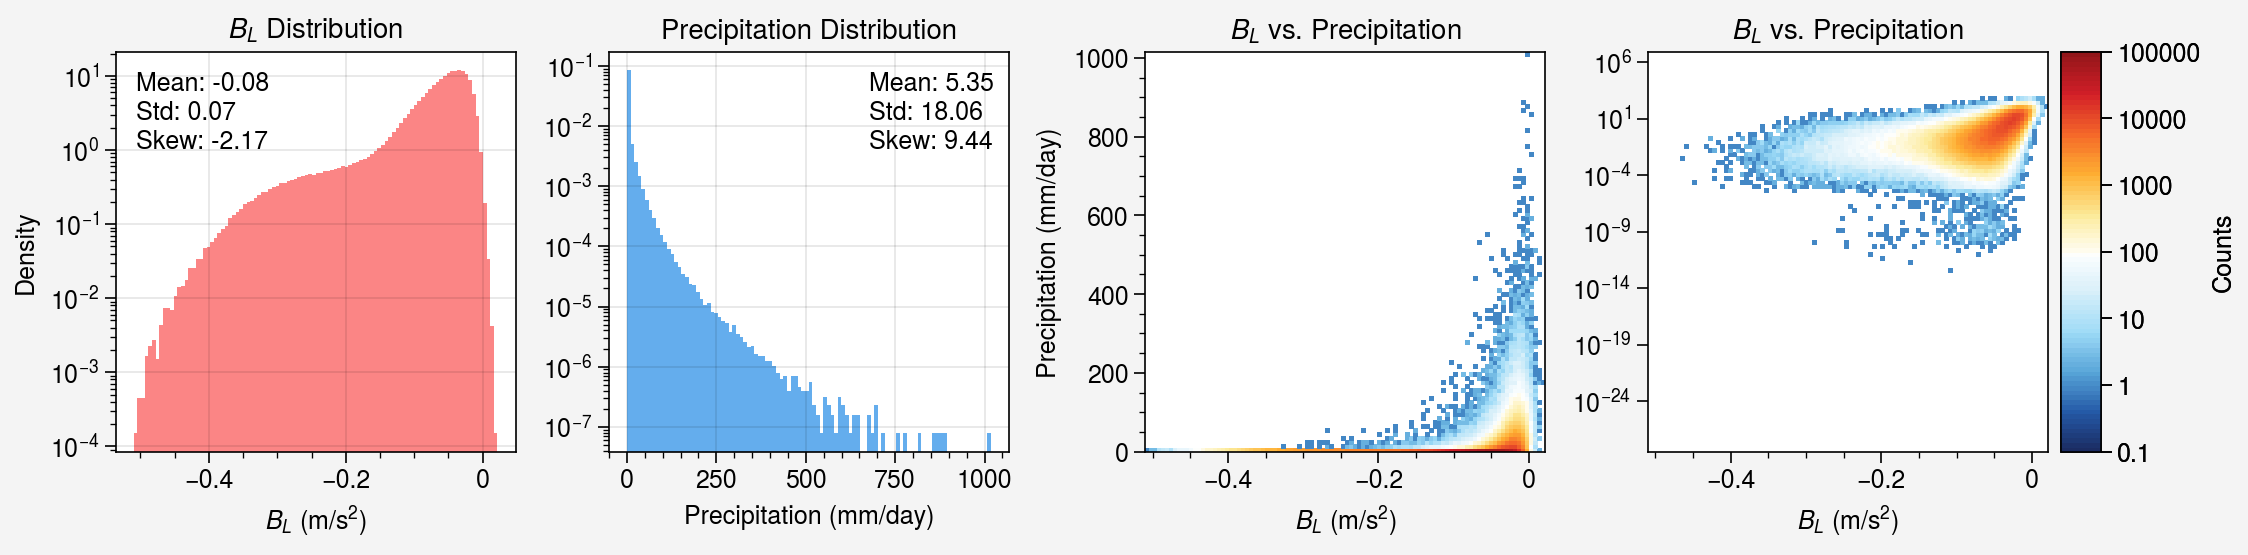

In [5]:
fig,axs = pplt.subplots(nrows=1,ncols=4,refwidth=2,share=False)
axs[0].format(title='$\mathit{B_L}$ Distribution',xlabel='$\mathit{B_L}$ (m/s$^2$)',ylabel='Density',yscale='log',yformatter='log')
axs[1].format(title='Precipitation Distribution',xlabel='Precipitation (mm/day)',yscale='log',yformatter='log')
axs[2].format(title='$\mathit{B_L}$ vs. Precipitation',xlabel='$\mathit{B_L}$ (m/s$^2$)',ylabel='Precipitation (mm/day)')
axs[3].format(title='$\mathit{B_L}$ vs. Precipitation',xlabel='$\mathit{B_L}$ (m/s$^2$)',yscale='log',yformatter='log')
axs[0].hist(x,bins=bins,density=True,color='red6',alpha=0.7)
axs[1].hist(y,bins=bins,density=True,color='blue6',alpha=0.7)
statsx = f'Mean: {np.mean(x):.2f}\nStd: {np.std(x):.2f}\nSkew: {stats.skew(x):.2f}'
statsy = f'Mean: {np.mean(y):.2f}\nStd: {np.std(y):.2f}\nSkew: {stats.skew(y):.2f}'
axs[0].text(0.05,0.95,statsx,transform=axs[0].transAxes,va='top')
axs[1].text(0.65,0.95,statsy,transform=axs[1].transAxes,va='top')
hist,xedges,yedges = np.histogram2d(x,y,bins=(bins,bins))
hist = np.ma.masked_where(hist==0,hist)
mesh = axs[2].pcolormesh(xedges,yedges,hist.T,cmap='ColdHot',norm='log',levels=100)
xedges = np.linspace(np.min(x),np.max(x),bins+1)
yedges = np.logspace(np.log(np.min(y[y>0])),np.log(np.max(y)),bins+1)
hist,_,_ = np.histogram2d(x,y,bins=(xedges,yedges))
hist = np.ma.masked_where(hist==0,hist)
meshlog = axs[3].pcolormesh(xedges,yedges,hist.T,cmap='ColdHot',norm='log',levels=100)
axs[3].colorbar(meshlog,label='Counts',ticks=[0.1,1,10,100,1000,10000,100000])
pplt.show()

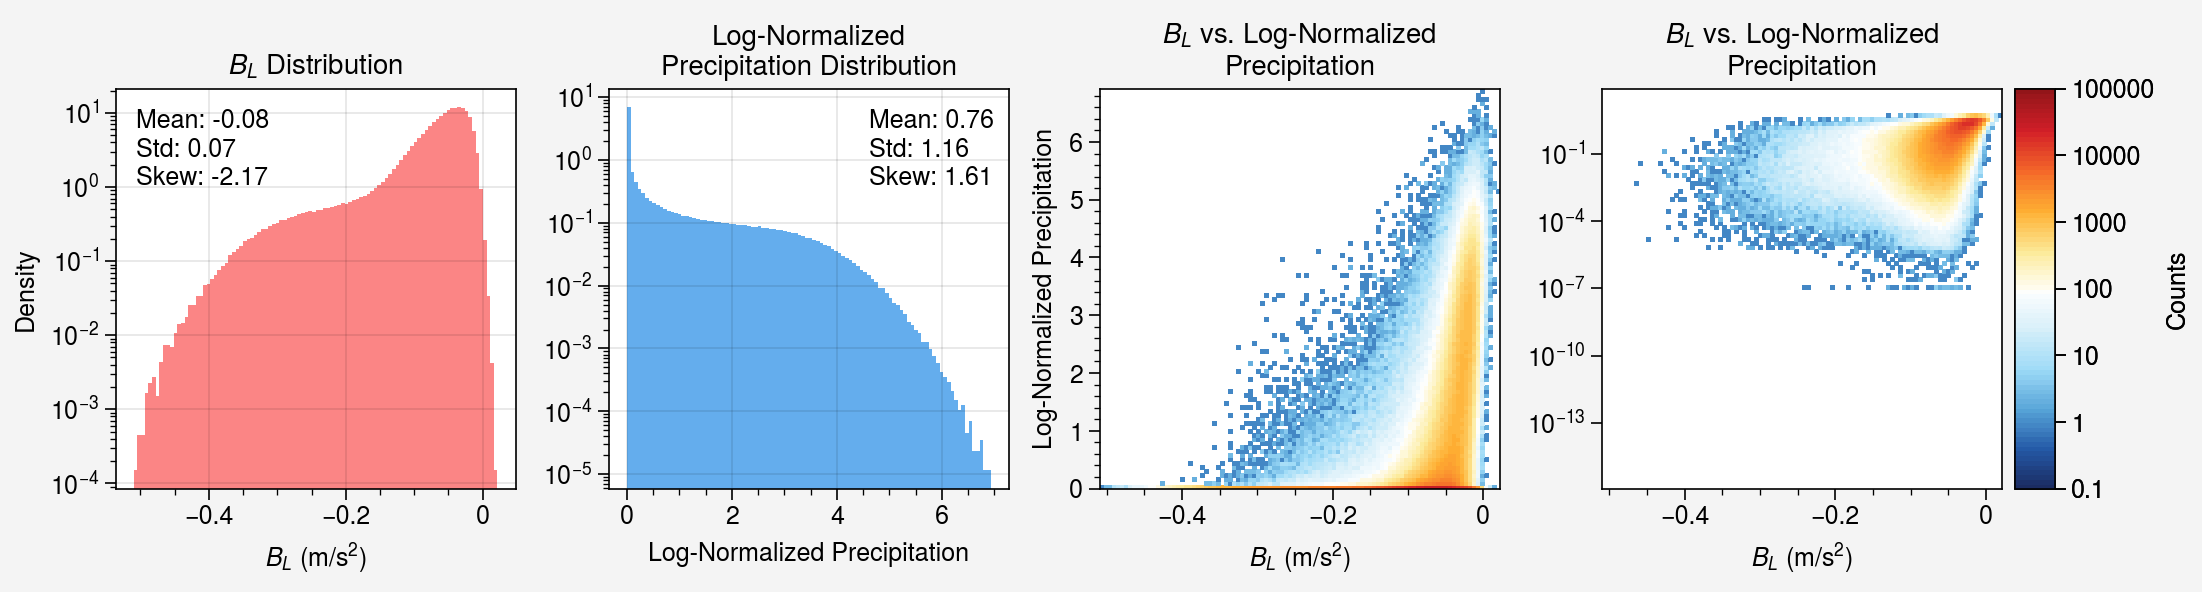

In [6]:
fig,axs = pplt.subplots(nrows=1,ncols=4,refwidth=2,share=False)
axs[0].format(title='$\mathit{B_L}$ Distribution',xlabel='$\mathit{B_L}$ (m/s$^2$)',ylabel='Density',yscale='log',yformatter='log')
axs[1].format(title='Log-Normalized\nPrecipitation Distribution',xlabel='Log-Normalized Precipitation',yscale='log',yformatter='log')
axs[2].format(title='$\mathit{B_L}$ vs. Log-Normalized\nPrecipitation',xlabel='$\mathit{B_L}$ (m/s$^2$)',ylabel='Log-Normalized Precipitation')
axs[3].format(title='$\mathit{B_L}$ vs. Log-Normalized\nPrecipitation',xlabel='$\mathit{B_L}$ (m/s$^2$)',yscale='log',yformatter='log')
axs[0].hist(x,bins=bins,density=True,color='red6',alpha=0.7)
axs[1].hist(ylog,bins=bins,density=True,color='blue6',alpha=0.7)
statsx = f'Mean: {np.mean(x):.2f}\nStd: {np.std(x):.2f}\nSkew: {stats.skew(x):.2f}'
statsy = f'Mean: {np.mean(ylog):.2f}\nStd: {np.std(ylog):.2f}\nSkew: {stats.skew(ylog):.2f}'
axs[0].text(0.05,0.95,statsx,transform=axs[0].transAxes,va='top')
axs[1].text(0.65,0.95,statsy,transform=axs[1].transAxes,va='top')
hist,xedges,yedges = np.histogram2d(x,ylog,bins=(bins,bins))
hist = np.ma.masked_where(hist==0,hist)
mesh = axs[2].pcolormesh(xedges,yedges,hist.T,cmap='ColdHot',norm='log',levels=100)
xedges = np.linspace(np.min(x),np.max(x),bins+1)
yedges = np.logspace(np.log(np.min(ylog[ylog>0])),np.log(np.max(ylog)),bins+1)
hist,_,_ = np.histogram2d(x,ylog,bins=(xedges,yedges))
hist = np.ma.masked_where(hist==0,hist)
meshlog = axs[3].pcolormesh(xedges,yedges,hist.T,cmap='ColdHot',norm='log',levels=100)
axs[3].colorbar(meshlog,label='Counts',ticks=[0.1,1,10,100,1000,10000,100000])
pplt.show()

In [43]:
class BASELINE:
    
    def __init__(self,binwidth,binmin,binmax,samplethresh):
        self.binwidth      = binwidth
        self.binmin        = binmin
        self.binmax        = binmax
        self.binedges      = np.arange(self.binmin,self.binmax+self.binwidth,self.binwidth)
        self.bincenters    = (self.binedges[:-1]+self.binedges[1:])/2
        self.nbins         = len(self.bincenters)
        self.samplethresh  = samplethresh
        self.model         = None

    def fit(self,inputs,targets):
        idxs  = np.digitize(inputs,self.binedges)-1
        Q0,Q1 = np.zeros(self.nbins),np.zeros(self.nbins)
        for i in range(targets.size):
            idx    = idxs[i]
            target = targets[i]
            if 0<=idx<self.nbins and np.isfinite(target):
                Q0[idx] += 1
                Q1[idx] += target
        with np.errstate(divide='ignore',invalid='ignore'):
            self.model = np.where(Q0>=self.samplethresh,Q1/Q0,np.nan)
        return (self.bincenters,self.model)

    def predict(self,inputs):
        binidxs = np.clip(np.digitize(inputs,self.binedges)-1,0,self.nbins-1)
        outputs = self.model[binidxs]
        outputs = np.maximum(outputs,0) # Enforce non-negative constraint
        return outputs
    
    # def evaluate(self,outputs,targets):
    #     mask    = ~np.isnan(outputs)&~np.isnan(targets)
    #     outputs = torch.FloatTensor(outputs[mask])
    #     targets = torch.FloatTensor(targets[mask])
    #     loss    = self.criterion(outputs,targets).item()
    #     return loss